In [75]:
from copy import deepcopy
import numpy as np
from typing import Dict
import networkx as nx
from matplotlib import pyplot as plt
import torch_geometric
from torch_geometric.data import Data

from src.envs.graph_coloring.gc_experimentation.problems import create_er_random_graph_problem
from src.envs.graph_coloring.gc_baselines.simple_policies import random_policy_without_newcolor
from src.envs.graph_coloring.gc_utils.plot_results import plot_gc_solution

In [76]:
def create_graph_from_observation(obs: Dict, with_attributes: bool = True) -> nx.Graph:
    """
    Create networkx graph from observation dictionary
    this creates a graph similar to the graph in the Env State
    :param obs: Dict of observation
    :param with_attributes: if True add attributes to graph
    :return: graph_nx: graph as networkx
    """
    # get relevant data from observation
    graph_nodes = list(obs['nodes_id'])
    graph_node_positions = deepcopy(obs["node_positions"])
    graph_colors = deepcopy(obs['node_colors'])
    graph_edges = deepcopy(obs['edge_indexes'])
    # create graph and add nodes and edges
    graph_nx = nx.Graph()
    graph_nx.add_nodes_from(graph_nodes)
    graph_nx.add_edges_from(graph_edges)
    # add attributes to graph
    if with_attributes:
        att_nodes = {i: {'color': c, 'start_time': 0, 'pos': p, 'indicator': 0} for i, c, p in
               zip(graph_nodes, graph_colors, graph_node_positions)}
        att_edges = {e: {'indicator': 0} for e in graph_nx.edges()}
        nx.set_node_attributes(graph_nx, att_nodes)
        nx.set_edge_attributes(graph_nx, values = att_edges)
    return graph_nx

In [77]:

def add_color_nodes_to_graph(obs: Dict, with_attributes: bool = True) -> nx.Graph:
    """
    Create graph from observation and add color nodes to graph. the new graph will include n+m+1 nodes
    where n - number of original nodes, m - number of used colors.
    there will be edges between all the un-colored nodes and colored nodes only if color is feasible on that node
    :param obs: Dict of simulation observation
    :param with_attributes: if True add attributes to graph
    :return: graph_nx: new graph of current state and color nodes
    """
    graph_nx = create_graph_from_observation(obs, with_attributes)
    num_original_nodes = len(list(obs['nodes_id']))
    extra_nodes = [i for i in range(num_original_nodes, num_original_nodes + len(obs["used_colors"]) + 1)]
    # create node position
    delta_pos = 2 / (len(obs["used_colors"]) + 1)
    extra_nodes_positions = [np.array([2, -1 + delta_pos * (1 + i)]) for i in range(len(obs["used_colors"]) + 1)]
    # add color feature
    extra_nodes_colors = deepcopy(obs["used_colors"])
    if len(obs["used_colors"]):
        new_color_index = 1 + max(obs["used_colors"])
    else:
        new_color_index = 0
    extra_nodes_colors.add(new_color_index)
    # add edges based on color constraints
    extra_edge_indexes = []
    extra_edge_att = {}
    for n in graph_nx.nodes():
        if graph_nx.nodes('color')[n] == -1:
            allowed_colors = deepcopy(extra_nodes_colors)
            for n_neighbor in graph_nx.neighbors(n):
                neighbor_color = graph_nx.nodes('color')[n_neighbor]
                if neighbor_color != -1 and neighbor_color in allowed_colors:
                    allowed_colors.remove(neighbor_color)
            for c in allowed_colors:
                extra_edge_indexes.append((n, c + num_original_nodes))
                extra_edge_att[(n, c + num_original_nodes)] = {'indicator': 1}
    graph_nx.add_nodes_from(extra_nodes)
    graph_nx.add_edges_from(extra_edge_indexes)
    if with_attributes:
        att = {i: {'color': c, 'start_time': 0, 'pos': p, 'indicator': 1} for i, c, p in
               zip(extra_nodes, extra_nodes_colors, extra_nodes_positions)}
        nx.set_node_attributes(graph_nx, att)
        nx.set_edge_attributes(graph_nx, extra_edge_att)
    return graph_nx

In [78]:
sim = create_er_random_graph_problem(num_new_nodes=0, num_initial_nodes=8, prob_edge=0.4,
                                   is_online=False, random_seed=0)

dict_keys(['node_colors', 'used_colors', 'nodes_id', 'edge_indexes', 'current_time', 'nodes_start_time', 'node_positions'])

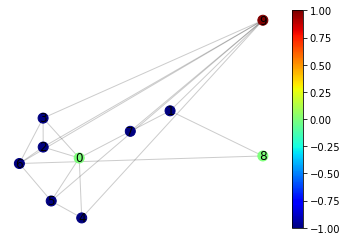

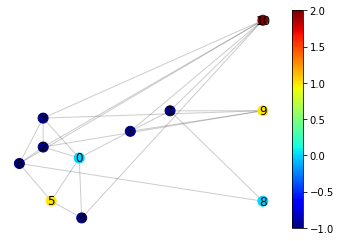

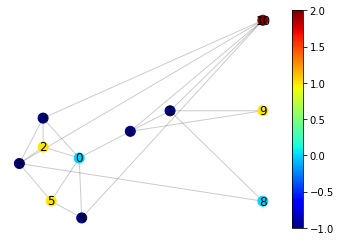

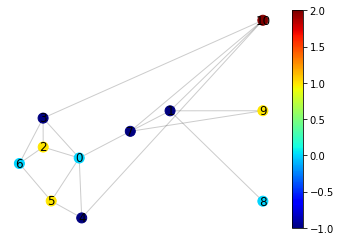

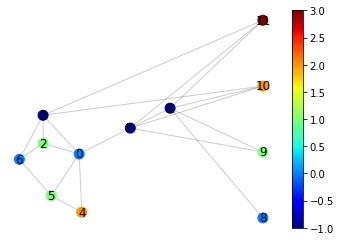

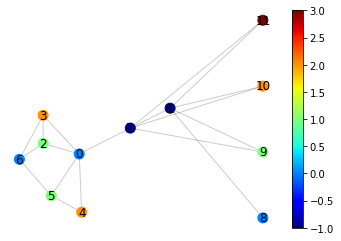

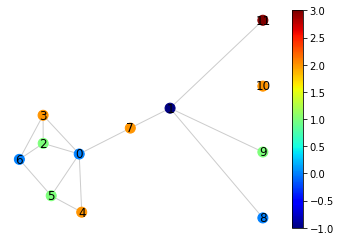

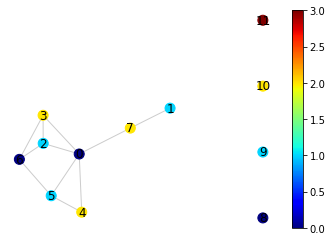

In [79]:
sim.seed(10)
obs = sim.reset()
is_done = False
while not is_done:
    obs, reward, is_done, _ = sim.step(random_policy_without_newcolor(obs, sim))
    graph_nx = create_graph_from_observation(obs)
    graph_nx_colors = add_color_nodes_to_graph(obs)
    plt.figure()
    plot_gc_solution(graph_nx_colors, [])

obs.keys()

In [39]:
graph_nx = add_color_nodes_to_graph(obs)
graph_nx.nodes(data=True)
node_features = []
for n,f in graph_nx.nodes(data=True):
    node_features.append(np.array([f['indicator'], f['color']]))
edge_features = []
for u, v, f in graph_nx.edges(data=True):
    edge_features.append(f['indicator'])
node_features_array = np.vstack(node_features)
edge_feature_array = np.vstack(edge_features)
graph_tg = torch_geometric.utils.from_networkx(graph_nx)
graph_tg.x = node_features_array
graph_tg.edge_attr = edge_feature_array 

In [41]:
graph_nx.edges(data=True)

EdgeDataView([(0, 2, {'indicator': 0}), (0, 3, {'indicator': 0}), (0, 4, {'indicator': 0}), (0, 5, {'indicator': 0}), (0, 7, {'indicator': 0}), (1, 7, {'indicator': 0}), (2, 3, {'indicator': 0}), (2, 6, {'indicator': 0}), (3, 6, {'indicator': 0}), (4, 5, {'indicator': 0}), (5, 6, {'indicator': 0})])

In [49]:
type(nx.linalg.graphmatrix.adjacency_matrix(graph_nx))

scipy.sparse.csr.csr_matrix

In [69]:
a = nx.linalg.graphmatrix.adjacency_matrix(graph_nx).toarray()
b = np.zeros(shape=(a.shape[0]+1))
c = np.zeros(shape=(b.shape[0], b.shape[0]))

In [70]:
for i in range(b.shape[0]):
    if np.random.random()>0.5:
        b[i] = 1 

In [71]:
c[: -1, :-1] = a
c[:, -1] = b
c[-1, :] = b

In [72]:
c

array([[0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.]])